In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        print("initialization")
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 1000       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.

#         self.func1 = nn.RNNCell(self.input_size, self.hidden_size)
        self.func1 = nn.GRUCell(self.input_size, self.hidden_size)##, num_layers=1, bidirectional = False)
        self.func2 = nn.Linear(self.hidden_size, self.output_size)
#         self.embedding = nn.Embedding(self.input_size, self.hidden_size)

        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
#         input = input.unsqueeze(0) 
#         print("hidden:")
#         print(hidden)
#         print(input.shape)
#         print(hidden.shape)
#         hidden = hidden.unsqueeze(0) 
#         if hidden.shape != input.shape:
#             hidden = hidden.unsqueeze(0)
#         print("after")
#         print (hidden.shape)
        hidden = self.func1(input, hidden)###### To be filled ######
#         print(hidden.shape)
        output = self.func2(hidden)###### To be filled ######
#         output = output.squeeze(0)
#         hidden = hidden.squeeze(0)
        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
#         return torch.zeros(1, self.hidden_size).to(device) 
        return torch.zeros(1, self.hidden_size).to(device) #, torch.zeros(1, self.hidden_size).to(device)
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

initialization


Net(
  (func1): GRUCell(100, 1000)
  (func2): Linear(in_features=1000, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.

    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
#         print(net(input, hidden))
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 12500  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/12500 loss:3.166240692138672
generated sequence: Wl, y thm othey y tr, acl yon thst ge yt msrl re, y yont nd mant d, NThid, thesaser th y af s cicst h

iter:199/12500 loss:2.6926932334899902
generated sequence: Whet
YCAY meced.
 te malince-thiLUCUTe ooper ent te tllence apin'd feortr,
An than?
Yel tarurt itiome

iter:299/12500 loss:2.6022839546203613
generated sequence: WBOSBOM:
Gl,.
Fis ay souix mule bnte Kat, cand iutoury raind an weard brecfind what dise er yo, kneti

iter:399/12500 loss:2.5595574378967285
generated sequence: Wis,
Nis.
And,
Norie, mwit his Carf hind bimy aid biphil mr,
NGREdi yarow's hershy orend and and
Norh

iter:499/12500 loss:2.4678821563720703
generated sequence: Wwe;
The me and hae poplllatn gharkelwmam:
The, whin placengl ha  gude an and
Hellos dim ine: chee pe

iter:599/12500 loss:2.475182056427002
generated sequence: What ' that tith thon t'lige prstis my ura mest, thar, obort?
Snducot ior, totl ueal,
ARCHe I seo mes

iter:699/12500 loss:2.437016963

#### Training Loss Curve

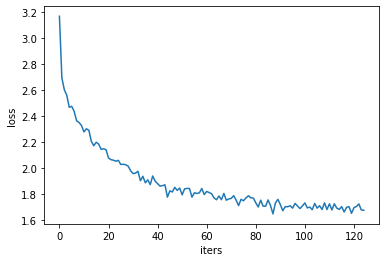

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

What?

BENVOLIO:
Voub! So, let this raze mans,
That me't this not here court my brother.

FERIAl book
Thou ladits flower's sends.
But as I more ender.

RIVERS:
I ten deen my looks uburnot thin hout, to someth tame.

LEONTEGONUS:
To,--

VILIONE:
How! A hath I parthing busables.
Alas I mants wither--Norry,
Partury thou that chounce deardex till may frues
To; I haves conce to-dien, I 'twas pless more.

MIRANA:
Seres my thow fot on of Cofiand-battled.

HERMIONE:
Yo knoble Nave thy worsh.

YORK:
Why, hew in groint, that, loft-butters, which I have her
Why, thou at the so morrolder.

VOLUMNIA:
Our wi


In [11]:
import numpy as np
f = open("GRU_10.npy", "w")
a = [data.item() for data in all_losses]
a

[3.166240692138672,
 2.6926932334899902,
 2.6022839546203613,
 2.5595574378967285,
 2.4678821563720703,
 2.475182056427002,
 2.4370169639587402,
 2.3643453121185303,
 2.3513429164886475,
 2.327972888946533,
 2.2786386013031006,
 2.3029978275299072,
 2.2911782264709473,
 2.206707715988159,
 2.1729025840759277,
 2.1996421813964844,
 2.185004234313965,
 2.145275354385376,
 2.1495301723480225,
 2.142252206802368,
 2.078425168991089,
 2.06612491607666,
 2.0618062019348145,
 2.0544357299804688,
 2.0608842372894287,
 2.0292537212371826,
 2.0308218002319336,
 2.0269994735717773,
 2.0167791843414307,
 1.980847716331482,
 1.9591175317764282,
 1.9626051187515259,
 1.9768818616867065,
 1.9040955305099487,
 1.9385664463043213,
 1.8885713815689087,
 1.911245584487915,
 1.8745777606964111,
 1.9409127235412598,
 1.9010143280029297,
 1.8817507028579712,
 1.8632577657699585,
 1.8667547702789307,
 1.8730299472808838,
 1.7782108783721924,
 1.8267192840576172,
 1.8182222843170166,
 1.8538448810577393,
 1.8

In [12]:
np.save("GRU_10.npy", a)
np.load("GRU_10.npy")

array([3.16624069, 2.69269323, 2.60228395, 2.55955744, 2.46788216,
       2.47518206, 2.43701696, 2.36434531, 2.35134292, 2.32797289,
       2.2786386 , 2.30299783, 2.29117823, 2.20670772, 2.17290258,
       2.19964218, 2.18500423, 2.14527535, 2.14953017, 2.14225221,
       2.07842517, 2.06612492, 2.0618062 , 2.05443573, 2.06088424,
       2.02925372, 2.0308218 , 2.02699947, 2.01677918, 1.98084772,
       1.95911753, 1.96260512, 1.97688186, 1.90409553, 1.93856645,
       1.88857138, 1.91124558, 1.87457776, 1.94091272, 1.90101433,
       1.8817507 , 1.86325777, 1.86675477, 1.87302995, 1.77821088,
       1.82671928, 1.81822228, 1.85384488, 1.83024049, 1.84842849,
       1.79618645, 1.84214365, 1.84534395, 1.84463692, 1.77876627,
       1.81183648, 1.80700326, 1.81099701, 1.84475303, 1.79863536,
       1.822492  , 1.81354797, 1.80479014, 1.7720778 , 1.75856233,
       1.78719294, 1.759197  , 1.80689514, 1.75530386, 1.76499689,
       1.76871657, 1.78992784, 1.75501692, 1.71400249, 1.76203

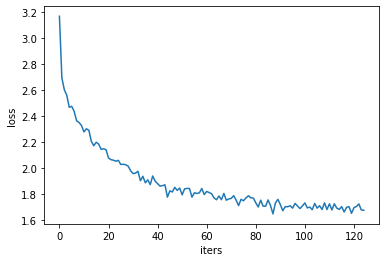

In [13]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("GRU_10.npy"))
plt.show()

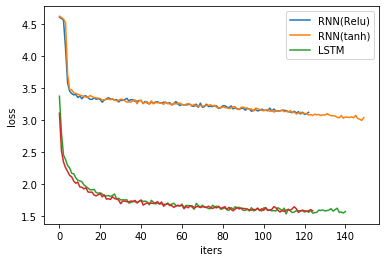

In [14]:
import numpy as np
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN.npy"), label='RNN(Relu)')
plt.plot(np.load("original_RNN_tanh.npy"), label='RNN(tanh)')
plt.plot(np.load("rnn_LSTM.npy"), label='LSTM')
plt.legend(loc='best')
plt.plot(np.load("GRU_100.npy"), label='GRU')
plt.show()